In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from tqdm import tqdm_notebook
from imageio import imread
import math
from data_loader_sims import DataLoader

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data and rescale all images to 32 by 32 pixels

In [2]:
path = 'Z:\Slim\Python_scripts\ML_NN\Simpsons\simpsons_dataset'
train_x, test_x, valid_x, train_y, test_y, valid_y, real_labels = DataLoader(resize_x=32, resize_y=32).read_split(path)


Data split.
Loading data from hdf5 file! Might take some time, be patient!


In [3]:
print("\nTraining set (images) shape: {}".format(train_x.shape))
print("Training set (labels) shape: {}".format(train_y.shape))

print("\nTest set (images) shape: {}".format(test_x.shape))
print("Test set (labels) shape: {}".format(test_y.shape))


Training set (images) shape: (15699, 96, 96, 3)
Training set (labels) shape: (15699, 42)

Test set (images) shape: (5234, 96, 96, 3)
Test set (labels) shape: (5234, 42)


# Show some image examples

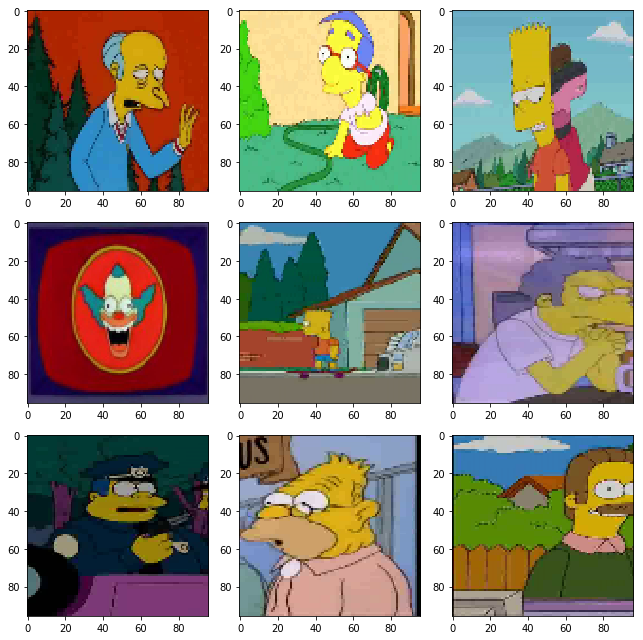

In [4]:
idx = np.random.randint(0, train_x.shape[0], size=9)

f, ax = plt.subplots(3, 3, figsize=(9, 9))
ax = ax.flatten()

for i in range(len(idx)):
    img = train_x[idx[i], :, :, :]
    ax[i].imshow(img)
    
    
plt.tight_layout()

### 2. Design CNN for characters classification.

In [5]:
class CNNConstructor():
    def __init__(self):
        self.active = True
        
    def init_weights(self, shape, name='W'):
        return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

    def init_biases(self, n_biases, name='B'):
        return tf.Variable(tf.constant(0.07, shape=[n_biases]))

    def conv_layer(self, input, kernel_size, n_channels, n_kernels,
                   conv_stride=1, padding='SAME', max_pooling=True,
                   pool_stride=2, name='Conv_layer'):

        conv_volume = [kernel_size, kernel_size, n_channels, n_kernels]

        weights = self.init_weights(shape=conv_volume)
        biases = self.init_biases(n_biases=n_kernels)

        conv_layer = tf.nn.conv2d(input,
                                  filter=weights,
                                  strides=[1, conv_stride, conv_stride, 1],
                                  padding=padding)

        conv_layer = tf.add(conv_layer, biases)

        if max_pooling:
            conv_layer = tf.nn.max_pool(conv_layer,
                                        ksize=[1, 2, 2, 1],
                                        strides=[1, pool_stride, pool_stride, 1],
                                        padding=padding)
        return tf.nn.relu(conv_layer), weights

    def flatten_conv_layer(self, conv_layer, name='Flatten_layer'):
        conv_shapes = conv_layer.get_shape()
        n_features = conv_shapes[1:4].num_elements()

        return tf.reshape(conv_layer, shape=[-1, n_features]), n_features

    def dense_layer(self, input, n_inputs, n_outputs, activation=True, name='Dense_layer'):
        weights = self.init_weights(shape=[n_inputs, n_outputs])
        biases = self.init_biases(n_biases=n_outputs)

        d_layer = tf.add(tf.matmul(input, weights), biases)

        if activation:
            d_layer = tf.nn.relu(d_layer)
        return d_layer

In [6]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [7]:
# Data parameters.
n_classes = 42
n_channels = 3
n_pixels = 96

# CNN parameters.
kernel_size = 3
n_kernels_l1 = 16
n_kernels_l2 = 32
n_neurons_fc = 64
epochs = 100
batch_size = 32

### 2.1 Define an architecture and initilize a computational graph

In [8]:
tf.reset_default_graph()

x_images = tf.placeholder(dtype=tf.float32, shape=[None, n_pixels, n_pixels, n_channels], name='Images')
y_characters = tf.placeholder(dtype=tf.float32, shape=[None, n_classes], name='Lables')

In [9]:
CNN = CNNConstructor()

l1, w1 = CNN.conv_layer(input=x_images, kernel_size=kernel_size, n_channels=n_channels, n_kernels=n_kernels_l1,
                        conv_stride=1, padding='SAME', max_pooling=True, pool_stride=2, name='Conv_1')

l2, w2 = CNN.conv_layer(input=l1, kernel_size=kernel_size, n_channels=n_kernels_l1, n_kernels=n_kernels_l2,
                        conv_stride=1, padding='SAME', max_pooling=True, pool_stride=2, name='Conv_2')

flatten, n_features = CNN.flatten_conv_layer(l2)
fc = CNN.dense_layer(input=flatten, n_inputs=n_features, n_outputs=n_neurons_fc, activation=True, name='Dense_1')

out_layer = CNN.dense_layer(input=fc, n_inputs=n_neurons_fc, n_outputs=n_classes, activation=False, name='Output')

In [10]:
prediction = tf.nn.softmax(out_layer)

# this adds a name to a node in the tensorboar
with tf.name_scope('Cross_Entropy'):  
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=out_layer,
                                                               labels=y_characters)
cost_function = tf.reduce_mean(cross_entropy)
with tf.name_scope('Loss_function'):  # this adds a name to a node in the tensorboar
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost_function)

# Evaluation
pred_character_cls = tf.argmax(out_layer, axis=1)
true_character_cls = tf.argmax(y_characters, axis=1)

with tf.name_scope('Accuracy'):
    correct_prediction = tf.equal(pred_character_cls, true_character_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 2.2 Train

In [12]:
batch_size = 32
n_batches = 25
epochs = 5
path_logs = 'Z:\Slim\Python_scripts\ML_NN\Simpsons\simpsons_dataset\logs'

session = tf.Session()
session.run(tf.global_variables_initializer())
accuaracy_values = []

merged = tf.summary.merge_all()
writer=tf.summary.FileWriter(path_logs) # creates file with tensorboard data stored
writer.add_graph(session.graph)         # writes data to the file,
                                        # for variables need to use merged = tf.summary.merge_all()
# to initialize the tensorboard use 'tensorboard --logdir=path' in cmd

for i in tqdm_notebook(range(epochs)):
    acc_epoch = []

    for j in tqdm_notebook(range(n_batches)):
        batch_x, batch_y = next_batch(batch_size, train_x, train_y)

        feed_train = {x_images: batch_x,
                      y_characters: batch_y}

        session.run(optimizer, feed_dict=feed_train)

        if j % 50 == 0:
            acc_j = session.run(accuracy, feed_dict=feed_train)
            acc_epoch.append(acc_j)
            msg = "Batch: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(j + 1, acc_j))
            #summary, acc = session.run([merged, accuracy], feed_dict=feed_train)
            #test_writer.add_summary(summary, j)

    acc = np.sum(acc_epoch)
    accuaracy_values.append(acc)

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Batch:      1, Training Accuracy:  12.5%


HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Batch:      1, Training Accuracy:  15.6%


HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Batch:      1, Training Accuracy:  12.5%


HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Batch:      1, Training Accuracy:  15.6%


HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Batch:      1, Training Accuracy:  12.5%


## 3. Plot filters

In [13]:
def plot_conv_weights(weights, input_channel=0):
    
    # Retrieve the values of the weight-variables
    w_values = session.run(weights)
    
    # Number of filters used in the conv. layer.
    n_kernels = w_values.shape[3]
    n_grids = math.ceil(np.sqrt(n_kernels))
    print('Total number of kernels: {} \n\t  Plotting grid: {}x{}'.format(n_kernels,
                                                                          n_grids,
                                                                          n_grids))
    # Plot.
    fig, axes = plt.subplots(n_grids, n_grids, figsize=(10, 10))
    axes = axes.flatten()
    
    for i, ax in enumerate(axes):
        if i < n_kernels:
            ax.imshow(w_values[:, :, input_channel, i],
                      vmin=np.min(w_values),
                      vmax=np.max(w_values),
                      interpolation='nearest',
                      cmap='viridis')
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
    return fig

def plot_conv_layer(layer, image):
    
    # Feed an image to the leyer of interest.
    feed_dict = {x_images: [image]}
    conv_values = session.run(layer, feed_dict=feed_dict)
    
    
    # Number of filters used in the conv. layer.
    n_kernels = conv_values.shape[3]
    n_grids = math.ceil(np.sqrt(n_kernels))
    print('Total number of kernels: {} \n\t  Plotting grid: {}x{}'.format(n_kernels,
                                                                          n_grids,
                                                                          n_grids))
    # Plot.
    fig, axes = plt.subplots(n_grids, n_grids, figsize=(10, 10))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < n_kernels:
            ax.imshow(conv_values[0, :, :, i],
                      interpolation='nearest',
                      cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()
    
    return fig

Total number of kernels: 32 
	  Plotting grid: 6x6


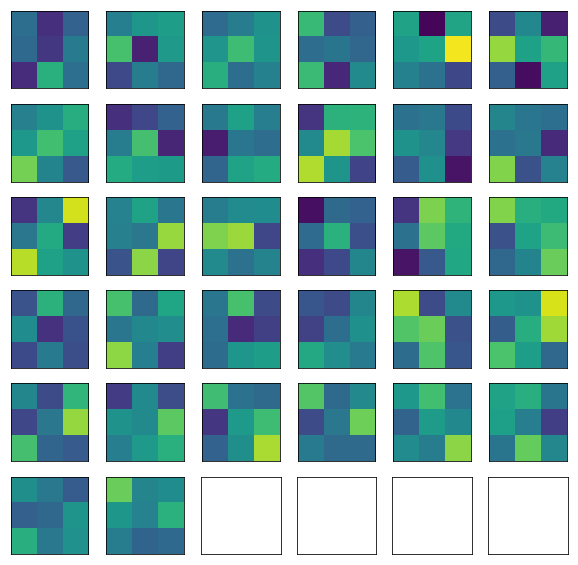

In [14]:
f_wights = plot_conv_weights(weights=w2)

Total number of kernels: 32 
	  Plotting grid: 6x6


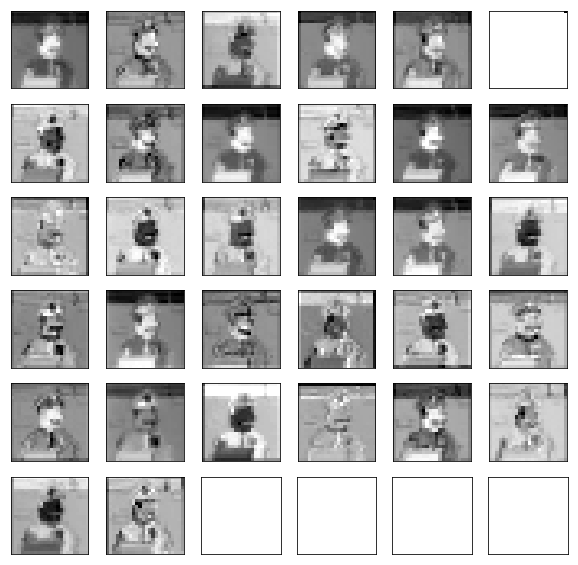

In [15]:
f_conv = plot_conv_layer(l2, image=test_x[94, :, :, :])